In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/motionsense-dataset/data_subjects_info.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/__MACOSX/A_DeviceMotion_data/dws_1/._sub_1.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/__MACOSX/A_DeviceMotion_data/jog_9/._sub_4.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/__MACOSX/A_DeviceMotion_data/jog_9/._sub_5.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/__MACOSX/A_DeviceMotion_data/wlk_7/._sub_13.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_16.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_18.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_3.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_12.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_1.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_4

In [37]:
# Setting up lists for importing the data.

list_of_folders = os.listdir(path)
list_of_directories = [path + i for i in list_of_folders]
list_of_dfs = []

activities = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

# Iterating through the directories and appending the dataframes for each subject in each of the trials to a list for further use.

for i in list_of_directories:
    list_of_csv = os.listdir(i)
    for j in list_of_csv:
        k = pd.read_csv(i + '/' + j).rename(columns={'Unnamed: 0': 'time'})
        k['subject'] = int(j.split('_')[1].split('.')[0])
        k['activity'] = i.split('/')[6].split('_')[0]
        k['trial'] = int(i.split('/')[6].split('_')[1])
        k.insert(0, 'accel_x', k['userAcceleration.x'] + k['gravity.x'])
        k.insert(1, 'accel_y', k['userAcceleration.y'] + k['gravity.y'])
        k.insert(2, 'accel_z', k['userAcceleration.z'] + k['gravity.z'])
        k.insert(3, 'accel_norm', np.sqrt(k['accel_x']**2 + k['accel_y']**2 + k['accel_z']**2))
        list_of_dfs.append(k)

# Creating one big dataframe (df) from the list of all individual dataframes. Dropping unnecessary columns and renaming the ones for rotation.

df = pd.concat(list_of_dfs).set_index('time')
df = df.drop(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'], axis=1)
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

NotADirectoryError: [Errno 20] Not a directory: '../input/motionsense-dataset/data_subjects_info.csv'

In [38]:
df

,accel_x,accel_y,accel_z,accel_norm,gyro_x,gyro_y,gyro_z,subject,activity,trial
time,,,,,,,,,,
0,0.454819,1.052780,-0.108917,1.151985,-0.055552,0.296486,-0.517680,16,dws,1
1,0.376831,0.929001,-0.066894,1.004748,-0.160723,0.148822,-0.528907,16,dws,1
2,0.321427,0.825241,0.012176,0.885712,-0.125106,0.032462,-0.498599,16,dws,1
3,0.286941,0.789627,0.009613,0.840201,0.135182,-0.113719,-0.398317,16,dws,1
4,0.284058,0.843247,-0.051727,0.891308,0.475710,-0.107196,-0.194053,16,dws,1
...,...,...,...,...,...,...,...,...,...,...
6859,0.101487,1.568817,-0.151886,1.579416,0.047839,-0.205053,-0.354167,7,wlk,7
6860,-0.389420,1.524643,0.047653,1.574311,-0.498880,0.069946,-0.452342,7,wlk,7
6861,-0.261795,1.058045,0.002655,1.089955,-0.519771,0.242518,0.098493,7,wlk,7


In [39]:
# Separating the dataframe into a training set and a test set. Making the cut between the long (1-9) and the short trials (11-16), with the short trials including one of each activity.

train_df = df[(df.trial < 10)]
test_df = df[(df.trial > 10)]

# Creating the features X and the targets y out of the training dataframe. Features are the seven columns for accelerometer (x,y,z,norm) and gyroscope (x,y,z).

X = train_df.iloc[:,:-3]
y = train_df.activity

In [40]:
# DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X, y)

DecisionTreeClassifier()

In [41]:
# Checking the model on the test set by activity.

def test_results(model, df):
    """
    
    Parameters
    ----------
    model : 
        DecisionTreeClassifier or RandomForestClassifier
    
    df : pd.DataFrame
        a dataframe on which the model makes predictions, including the activity column as target
        
    Returns
    -------
        prints out a list of the accuracy of the model on the dataframe for each activity

    """
    correct = 0
    total = 0
    for i in activities:
        k = df.iloc[:,:-3][(df.activity == i)]
        preds = model.predict(k)
        print(i + ': ' + str(((preds == i).sum() / len(preds))*100) + '%')
        correct += (preds == i).sum()
        total += len(preds)
    print('total: ' + str(correct / total * 100) + '%')

In [42]:
test_results(dtc, test_df)

dws: 39.689805350635496%
ups: 43.08258059909315%
sit: 99.09720421432756%
std: 92.0500912867138%
wlk: 58.33588675082731%
jog: 58.53397538790798%
total: 76.90657445710717%


In [43]:
test_df.activity.value_counts()

sit    104121
std     81611
wlk     65272
jog     29904
ups     28009
dws     22502
Name: activity, dtype: int64

In [44]:
# RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X, y)

RandomForestClassifier(n_estimators=10)

In [45]:
test_results(rfc, test_df)

dws: 46.76917607323794%
ups: 46.874219001035385%
sit: 98.86382189952076%
std: 93.48372155714303%
wlk: 67.53278588062263%
jog: 67.36222578919208%
total: 80.59525856996731%


In [46]:
# Creating a neural network with the keras library.

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

# Using LabelEncoder to convert the targets (6 activities) by one-hot-encoding to a binary matrix (dummy_y).

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)

In [50]:
# Creating the model.

cnn = Sequential()
cnn.add(Dense(80, input_dim=7, activation='relu'))
cnn.add(Dense(40, activation='relu'))
cnn.add(Dense(20, activation='relu'))
cnn.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.01)

cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_X, val_X, train_y, val_y = train_test_split(X, dummy_y, shuffle=True)

2022-10-20 04:26:11.905177: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
4056/4056 [==============================] - 15s 4ms/step - loss: 0.6154 - accuracy: 0.7495 - val_loss: 0.5766 - val_accuracy: 0.7680
Epoch 2/10
4056/4056 [==============================] - 15s 4ms/step - loss: 0.5707 - accuracy: 0.7717 - val_loss: 0.5649 - val_accuracy: 0.7751
Epoch 3/10
4056/4056 [==============================] - 15s 4ms/step - loss: 0.5594 - accuracy: 0.7778 - val_loss: 0.5560 - val_accuracy: 0.7797
Epoch 4/10
4056/4056 [==============================] - 16s 4ms/step - loss: 0.5527 - accuracy: 0.7811 - val_loss: 0.5492 - val_accuracy: 0.7848
Epoch 5/10
4056/4056 [==============================] - 16s 4ms/step - loss: 0.5479 - accuracy: 0.7838 - val_loss: 0.5458 - val_accuracy: 0.7848
Epoch 6/10
4056/4056 [==============================] - 16s 4ms/step - loss: 0.5450 - accuracy: 0.7853 - val_loss: 0.5446 - val_accuracy: 0.7866
Epoch 7/10
4056/4056 [==============================] - 16s 4ms/step - loss: 0.5422 - accuracy: 0.7868 - val_loss: 0.5525 - val_ac

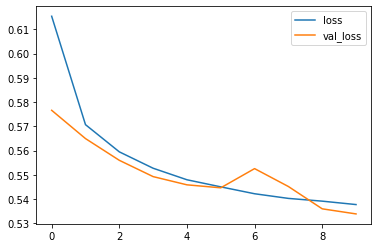

In [51]:
history = cnn.fit(train_X, train_y, epochs=10, batch_size=200, validation_data=(val_X, val_y))
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

In [53]:
def cnn_test_results(model, df):
    """
    
    Parameters
    ----------
    model : tf.keras.Sequential()
        a model in form of a convolutional neural network, Sequential used here
    
    df : pd.DataFrame
        a dataframe on which the model makes predictions, including the activity column as target

    Returns
    -------
        prints out a list of the accuracy of the model on the dataframe for each activity

    """    
    correct = 0
    total = 0
    for i in activities:
        k = df.iloc[:,:-3][(df.activity == i)]
        preds = model.predict(k)
        encoder = LabelEncoder()
        encoder.fit(df.activity)
        l = []
        for j in range(len(preds)):
            l.append(list(encoder.classes_)[np.argmax(preds[j])])
        accuracy = sum([l[j] == i for j in range(len(l))])/len(l)
        print(i + ': ' + str(accuracy*100) + '%')
        correct += sum([l[j] == i for j in range(len(l))])
        total += len(l)
    print('total: ' + str(correct / total * 100) + '%')

In [54]:
cnn_test_results(cnn, test_df)

dws: 31.77050928806328%
ups: 36.89171337784284%
sit: 92.42035708454587%
std: 93.46166570682874%
wlk: 77.15712709890919%
jog: 64.72043873729267%
total: 78.36062506977572%


In [55]:
def create_lag_features(n, cols):
    """

    Parameters
    ----------
    n : int
        amount of lag features
    cols : list
        list of columns to lag

    Returns
    -------
    pd.DataFrame
        a dataframe with the list of columns lagged n times

    """

    lag_features = n
    lag_df = df.copy()

    for j in cols:
        for i in range(lag_features):
            lag_df.insert(7+i, j + '_lag' + str(i+1), lag_df[j].shift(i+1))
        
    # Dropping all rows where the lag overlapped two different subjects/trials (n timeframes at the beginning of every trial).

    for i in range(lag_features):
        lag_df = lag_df.drop([i])
    
    return lag_df


In [56]:
lag_df = create_lag_features(50, ['accel_norm'])
lag_df.head()

,accel_x,accel_y,accel_z,accel_norm,gyro_x,gyro_y,gyro_z,accel_norm_lag1,accel_norm_lag2,accel_norm_lag3,...,accel_norm_lag44,accel_norm_lag45,accel_norm_lag46,accel_norm_lag47,accel_norm_lag48,accel_norm_lag49,accel_norm_lag50,subject,activity,trial
time,,,,,,,,,,,,,,,,,,,,,
50,0.130737,0.636841,0.025208,0.650611,1.135523,-0.807769,0.192803,0.728929,0.798274,0.982435,...,0.825510,0.825510,0.891308,0.840201,0.885712,1.004748,1.151985,16,dws,1
51,0.093628,0.609055,-0.068696,0.620027,1.576694,-0.883927,0.473720,0.650611,0.728929,0.798274,...,0.612106,0.825510,0.825510,0.891308,0.840201,0.885712,1.004748,16,dws,1
52,0.041718,0.671433,-0.156692,0.690735,2.215764,-0.635747,0.725694,0.620027,0.650611,0.728929,...,0.746748,0.612106,0.825510,0.825510,0.891308,0.840201,0.885712,16,dws,1
53,-0.072861,0.664520,-0.209060,0.700430,2.916685,-0.277571,0.856181,0.690735,0.620027,0.650611,...,0.746747,0.746748,0.612106,0.825510,0.825510,0.891308,0.840201,16,dws,1
54,-0.130996,0.597657,-0.197174,0.642831,2.889665,-0.057207,0.916598,0.700430,0.690735,0.620027,...,0.866394,0.746747,0.746748,0.612106,0.825510,0.825510,0.891308,16,dws,1


In [57]:
# Training and test sets with lag and the corresponding features and targets.

lag_train_df = lag_df[(lag_df.trial < 10)]
lag_test_df = lag_df[(lag_df.trial > 10)]

lag_X = lag_train_df.iloc[:,:-3]
lag_y = lag_train_df.activity

In [58]:
# RandomForestClassifier

lag_rfc = RandomForestClassifier(n_estimators=10)
lag_rfc.fit(lag_X, lag_y)

RandomForestClassifier(n_estimators=10)

In [59]:
test_results(lag_rfc, lag_test_df)

dws: 81.41019622570651%
ups: 78.97720914618225%
sit: 99.80761943626665%
std: 95.9259305318924%
wlk: 94.67474091646896%
jog: 94.60702341137124%
total: 94.43894404707929%


In [60]:
# Neural network for lag features.

import tensorflow as tf

lag_features = 50

lag_cnn = Sequential()
lag_cnn.add(Dense(64, input_dim=7+lag_features, activation='relu'))
lag_cnn.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
lag_cnn.add(Dense(16, activation='relu'))
lag_cnn.add(Dense(6, activation='softmax'))

lag_opt = keras.optimizers.Adam(learning_rate=0.01)

lag_cnn.compile(loss='categorical_crossentropy', optimizer=lag_opt, metrics=['accuracy'])

In [61]:
# Encoding the targets by one-hot-encoding to a binary matrix (lag_dummy_y).

lag_encoder = LabelEncoder()
lag_encoder.fit(lag_y)
lag_encoded_y = lag_encoder.transform(lag_y)

lag_dummy_y = np_utils.to_categorical(lag_encoded_y)

lag_train_X, lag_val_X, lag_train_y, lag_val_y = train_test_split(lag_X, lag_dummy_y, shuffle=True)

Epoch 1/10
4015/4015 [==============================] - 16s 4ms/step - loss: 0.4568 - accuracy: 0.8433 - val_loss: 0.3614 - val_accuracy: 0.8815
Epoch 2/10
4015/4015 [==============================] - 14s 4ms/step - loss: 0.3498 - accuracy: 0.8838 - val_loss: 0.3251 - val_accuracy: 0.8926
Epoch 3/10
4015/4015 [==============================] - 14s 3ms/step - loss: 0.3211 - accuracy: 0.8937 - val_loss: 0.3327 - val_accuracy: 0.8897
Epoch 4/10
4015/4015 [==============================] - 14s 4ms/step - loss: 0.3116 - accuracy: 0.8978 - val_loss: 0.3160 - val_accuracy: 0.8971
Epoch 5/10
4015/4015 [==============================] - 14s 3ms/step - loss: 0.3070 - accuracy: 0.8997 - val_loss: 0.3058 - val_accuracy: 0.9000
Epoch 6/10
4015/4015 [==============================] - 14s 4ms/step - loss: 0.3030 - accuracy: 0.9012 - val_loss: 0.2911 - val_accuracy: 0.9054
Epoch 7/10
4015/4015 [==============================] - 14s 3ms/step - loss: 0.3004 - accuracy: 0.9020 - val_loss: 0.2965 - val_ac

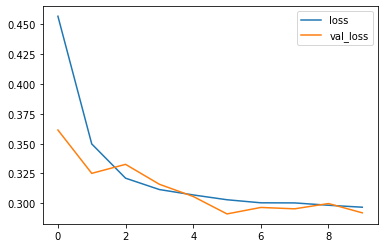

In [62]:
history = lag_cnn.fit(lag_train_X, lag_train_y, epochs=10, batch_size=200, validation_data=(lag_val_X, lag_val_y))
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

In [63]:
cnn_test_results(lag_cnn, lag_test_df)

dws: 62.40728570087316%
ups: 73.61333880413295%
sit: 89.29955985658904%
std: 95.45211476041835%
wlk: 93.60719190910226%
jog: 93.85103121516165%
total: 89.01575786736743%


In [64]:
# Quick function for generating a list of the predictions to compare with the targets, instead of a matrix of their probabilities.

def cnn_pred_list(model, df):
    """
    
    Parameters
    ----------
    model : tf.keras.Sequential()
        a model in form of a convolutional neural network, Sequential used here
    
    df : pd.DataFrame
        a dataframe on which the model makes predictions, including the activity column as target

    Returns
    -------
    l : list
        a list of the encrypted predictions of the model
    
    y : pd.Series
        the target vector to compare with the prediction list
    
    """
    l = []
    X = df.iloc[:,:-3]
    y = df.activity
    preds = model.predict(X)
    encoder = LabelEncoder()
    encoder.fit(y)
    for i in range(len(preds)):
        l.append(list(encoder.classes_)[np.argmax(preds[i])])
    return l, y

In [65]:
lag_pred, lag_y = cnn_pred_list(lag_cnn, lag_test_df)

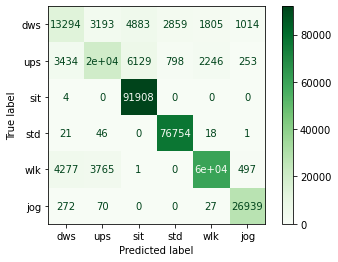

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(lag_pred, lag_y, labels=activities)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=activities)
conf_mat_disp.plot(cmap='Greens')
plt.show()

In [67]:
# Creating rolling feature columns.

def create_feature_columns(k):
    """
    
    Parameters
    ----------
    k : int
        the amount of steps for the rolling features

    Returns
    -------
    pd.Dataframe
        a new dataframe with rolling features over k steps

    """
    
    feat_df = df.copy()
    cols = feat_df.iloc[:,:-3].columns

    j = 1
    for i in cols:
        feat_df.insert(j, f'{i}_rmean', feat_df[i].rolling(k).mean())
        feat_df.insert(j+1, f'{i}_rstd', feat_df[i].rolling(k).std())
        feat_df.insert(j+2, f'{i}_rmed', feat_df[i].rolling(k).median())
        #feat_df.insert(j+3, f'{i}_rskew', feat_df[i].rolling(k).skew())
        #feat_df.insert(j+4, f'{i}_rmax', feat_df[i].rolling(k).max())
        #feat_df.insert(j+5, f'{i}_rmin', feat_df[i].rolling(k).min())
        #feat_df.insert(j+6, f'{i}_squared', feat_df[i]**2)
        j += 4

    # Dropping all rows where the lag overlapped two different subjects/trials.

    for i in range(k):
        feat_df = feat_df.drop([i])
    
    return feat_df

In [68]:
feat_df = create_feature_columns(150)

In [69]:
feat_df

,accel_x,accel_x_rmean,accel_x_rstd,accel_x_rmed,accel_y,accel_y_rmean,accel_y_rstd,accel_y_rmed,accel_z,accel_z_rmean,...,gyro_y_rmean,gyro_y_rstd,gyro_y_rmed,gyro_z,gyro_z_rmean,gyro_z_rstd,gyro_z_rmed,subject,activity,trial
time,,,,,,,,,,,,,,,,,,,,,
150,-0.252700,0.266308,0.290877,0.285499,0.778031,0.912268,0.439799,0.815392,-0.150726,-0.250131,...,0.034013,0.480562,0.030090,-0.005361,0.014811,0.804590,-0.040035,16,dws,1
151,-0.245972,0.262156,0.293720,0.281883,0.339157,0.908335,0.442278,0.811051,0.100784,-0.249013,...,0.030929,0.481304,0.022535,-0.268671,0.016546,0.803689,-0.040035,16,dws,1
152,-0.086731,0.259435,0.295054,0.276253,0.288132,0.904755,0.445120,0.809868,0.112000,-0.248348,...,0.029163,0.481784,0.016206,-0.365836,0.017431,0.803191,-0.040035,16,dws,1
153,0.032562,0.257739,0.295626,0.272629,0.448700,0.902482,0.446580,0.809868,0.052536,-0.248062,...,0.026189,0.484044,0.016206,-0.313615,0.017996,0.802927,-0.040035,16,dws,1
154,0.327210,0.258027,0.295672,0.272629,2.036118,0.910434,0.456039,0.809868,0.216187,-0.246276,...,0.022567,0.487073,0.016206,-0.222199,0.017809,0.802980,-0.040035,16,dws,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859,0.101487,-0.024802,0.239415,0.019738,1.568817,1.006227,0.406361,0.975129,-0.151886,-0.026296,...,-0.103489,0.711646,-0.013985,-0.354167,0.139480,0.963486,-0.094505,7,wlk,7
6860,-0.389420,-0.026792,0.241202,0.019738,1.524643,1.009447,0.408551,0.975129,0.047653,-0.026352,...,-0.105814,0.710497,-0.013985,-0.452342,0.140182,0.963013,-0.094505,7,wlk,7
6861,-0.261795,-0.027678,0.241823,0.019738,1.058045,1.009138,0.408496,0.975129,0.002655,-0.026852,...,-0.108328,0.708578,-0.013985,0.098493,0.144218,0.961550,-0.081249,7,wlk,7


In [70]:
feat_train_df = feat_df[(feat_df.trial < 10)]
feat_test_df = feat_df[(feat_df.trial > 10)]

feat_X = feat_train_df.iloc[:,:-3]
feat_y = feat_train_df.activity

In [71]:
# RandomForestClassifier

feat_rfc = RandomForestClassifier(n_estimators=10)
feat_rfc.fit(feat_X, feat_y)

RandomForestClassifier(n_estimators=10)

In [72]:
test_results(feat_rfc, feat_test_df)

dws: 98.4816421542694%
ups: 94.49793109099103%
sit: 100.0%
std: 95.84417582135852%
wlk: 88.00914515501363%
jog: 95.25927615571777%
total: 95.6380983735665%


In [74]:
# CNN Model for feature df:

import tensorflow as tf
from keras.layers import Dropout

extra_features = 21

feat_cnn = Sequential()
feat_cnn.add(Dense(64, input_dim=7+extra_features, activation='relu'))
feat_cnn.add(Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
feat_cnn.add(Dropout(0.2))
feat_cnn.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
feat_cnn.add(Dropout(0.5))
feat_cnn.add(Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
feat_cnn.add(Dense(6, activation='softmax'))

feat_opt = keras.optimizers.Adam(learning_rate=0.01)

feat_cnn.compile(loss='categorical_crossentropy', optimizer=feat_opt, metrics=['accuracy'])

In [75]:
feat_encoder = LabelEncoder()
feat_encoder.fit(feat_y)
feat_encoded_y = feat_encoder.transform(feat_y)

feat_dummy_y = np_utils.to_categorical(feat_encoded_y)

feat_train_X, feat_val_X, feat_train_y, feat_val_y = train_test_split(feat_X, feat_dummy_y, shuffle=True, random_state=420)

In [77]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

Epoch 1/50
3934/3934 [==============================] - 22s 5ms/step - loss: 0.3588 - accuracy: 0.9300 - val_loss: 0.2011 - val_accuracy: 0.9758
Epoch 2/50
3934/3934 [==============================] - 20s 5ms/step - loss: 0.2373 - accuracy: 0.9633 - val_loss: 0.1974 - val_accuracy: 0.9778
Epoch 3/50
3934/3934 [==============================] - 20s 5ms/step - loss: 0.2211 - accuracy: 0.9654 - val_loss: 0.1660 - val_accuracy: 0.9807
Epoch 4/50
3934/3934 [==============================] - 20s 5ms/step - loss: 0.2127 - accuracy: 0.9667 - val_loss: 0.1687 - val_accuracy: 0.9801
Epoch 5/50
3934/3934 [==============================] - 19s 5ms/step - loss: 0.2111 - accuracy: 0.9661 - val_loss: 0.1660 - val_accuracy: 0.9793
Epoch 6/50
3934/3934 [==============================] - 19s 5ms/step - loss: 0.2073 - accuracy: 0.9676 - val_loss: 0.1720 - val_accuracy: 0.9760
Epoch 7/50
3934/3934 [==============================] - 18s 5ms/step - loss: 0.2018 - accuracy: 0.9684 - val_loss: 0.1623 - val_ac

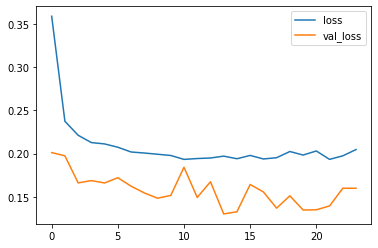

In [78]:
history = feat_cnn.fit(feat_train_X, feat_train_y, epochs=50, batch_size=200, validation_data=(feat_val_X, feat_val_y), callbacks=[early_stopping])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

In [80]:
cnn_test_results(feat_cnn, feat_test_df)

dws: 98.60861284520158%
ups: 94.15789258060552%
sit: 100.0%
std: 95.98774531796798%
wlk: 92.69198339603061%
jog: 95.33911192214111%
total: 96.59414044974646%


In [81]:
feat_pred, feat_targ = cnn_pred_list(feat_cnn, feat_test_df)

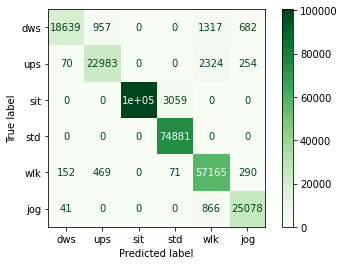

In [82]:
# Confusion Matrix:

conf_mat = confusion_matrix(feat_pred, feat_targ, labels=activities)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=activities)
conf_mat_disp.plot(cmap='Greens')
plt.show()